In [200]:
import pandas as pd
from pgmpy.factors.discrete import TabularCPD

class BayesianCPTBuilder:
    def __init__(self, filepath):
        self.df = pd.read_csv(filepath)
        self.df = self.df.rename(columns={
            'gender': 'Gender',
            'feature': 'AgeGroup',
            'median_income': 'IncomeLevel',
            'PROPORTION': 'Proportion'
        })
        self.genders = sorted(self.df['Gender'].unique())
        self.age_groups = sorted(self.df['AgeGroup'].unique())
        self.income_levels = sorted(self.df['IncomeLevel'].unique())
        # 自动归一化 PROPORTION 列
        # self._normalize_proportions()

    # def _normalize_proportions(self):
    #     if 'IncomeLevel' in self.df.columns:
    #         multiplyer = self.df.groupby(['Gender', 'AgeGroup']).sum(numeric_only=True).sum()

    #     # 归一化每组的 PROPORTION，使每个条件组合下的概率和为 1
    #     self.df['Proportion'] = self.df['Proportion'] / multiplyer['Proportion']
    def _normalize_proportions(self):
        # 按 Gender 分组，计算每个性别的总量
        total_by_gender = self.df.groupby('Gender')['Proportion'].sum()

        # 对每行进行归一化：除以该行对应性别的总量
        self.df['Proportion'] = self.df.apply(
            lambda row: row['Proportion'] / total_by_gender[row['Gender']],
            axis=1
        )
    
    def build_age_given_gender_cpd(self):
        cpt_matrix = []
        for age in self.age_groups:
            row = []
            for gender in self.genders:
                prob = self.df[
                    (self.df['Gender'] == gender) & (self.df['AgeGroup'] == age)
                ]['Proportion'].values
                row.append(prob[0] if len(prob) > 0 else 0.0)
            cpt_matrix.append(row)

        return TabularCPD(
            variable='AgeGroup',
            variable_card=len(self.age_groups),
            values=cpt_matrix,
            evidence=['Gender'],
            evidence_card=[len(self.genders)],
            state_names={
                'AgeGroup': self.age_groups,
                'Gender': self.genders
            }
        )

    def build_income_given_age_cpd(self):
        cpt_matrix = []

        for income in self.income_levels:
            row = []
            for age in self.age_groups:
                prob = self.df[
                    (self.df['AgeGroup'] == age) &
                    (self.df['IncomeLevel'] == income)
                ]['Proportion'].sum()  # 合并不同性别的比例
                row.append(prob)
            cpt_matrix.append(row)

        # 每列是一个 AgeGroup，按列归一化
        import numpy as np
        cpt_array = np.array(cpt_matrix)
        col_sums = cpt_array.sum(axis=0)
        normalized_matrix = (cpt_array / col_sums).tolist()

        return TabularCPD(
            variable='IncomeLevel',
            variable_card=len(self.income_levels),
            values=normalized_matrix,
            evidence=['AgeGroup'],
            evidence_card=[len(self.age_groups)],
            state_names={
                'IncomeLevel': self.income_levels,
                'AgeGroup': self.age_groups
            }
        )


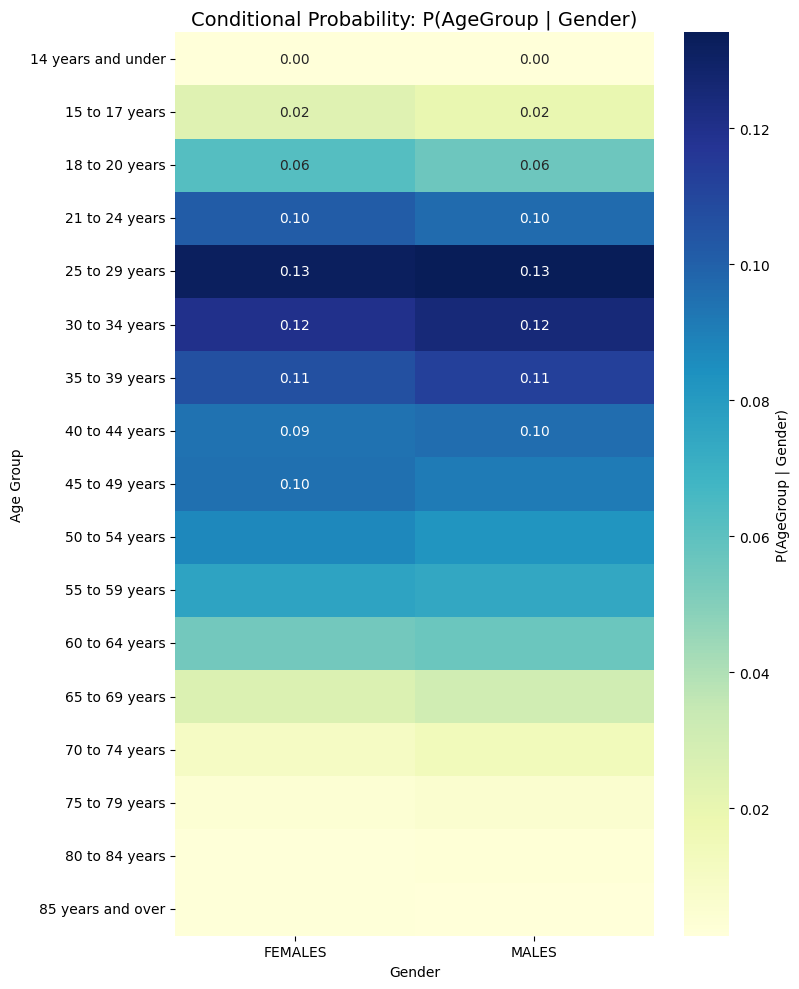

In [ ]:
##CPT可视化热力图 TODO

# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt

# # 读取整理后的 CPT 数据
# df = pd.read_csv("Age_group_gender_transformed.csv")

# # 重命名列方便处理
# df = df.rename(columns={'feature': 'AgeGroup', 'gender': 'Gender', 'PROPORTION': 'Probability'})

# # 创建透视表：行是年龄组，列是性别，值是概率
# pivot_df = df.pivot(index='AgeGroup', columns='Gender', values='Probability')

# # 设置图形大小
# plt.figure(figsize=(8, 10))

# # 绘制热力图
# sns.heatmap(
#     pivot_df,
#     annot=True, fmt=".2f", cmap="YlGnBu",
#     cbar_kws={'label': 'P(AgeGroup | Gender)'}
# )

# # 设置标题和轴标签
# plt.title("Conditional Probability: P(AgeGroup | Gender)", fontsize=14)
# plt.xlabel("Gender")
# plt.ylabel("Age Group")

# # 显示图形
# plt.tight_layout()
# plt.show()


In [201]:
# 构建BN框架
from pgmpy.models import DiscreteBayesianNetwork

#TODO modify file path later
builder = BayesianCPTBuilder("age_gender_transformed_v3.csv")
gender_proportions = builder.df.groupby('Gender')['Proportion'].sum()
cpd_age = builder.build_age_given_gender_cpd()
cpd_age.normalize()
cpd_income = builder.build_income_given_age_cpd()
cpd_income.normalize()

# 定义结构：Gender → AgeGroup
model = DiscreteBayesianNetwork([('Gender', 'AgeGroup'), ('AgeGroup', 'IncomeLevel')])
# model.add_cpds(cpd_age)
# model.add_cpds(cpd_income)
model.add_cpds(cpd_age, cpd_income)


In [ ]:
# tmp_df = pd.read_csv("Age group_gender_transformed.csv")
# tmp_df.groupby(['gender', 'feature'])['PROPORTION'].sum().sum()

0.9997152745231273

In [202]:
# 加入先验gender概率
from pgmpy.factors.discrete import TabularCPD

cpd_gender = TabularCPD(
    variable='Gender',
    variable_card=2,
    values=[[gender_proportions['FEMALES']], [gender_proportions['MALES']]],
    state_names={'Gender': ['FEMALES', 'MALES']}
)
model.add_cpds(cpd_gender)
# 检查模型是否有效（所有节点都有 CPT，结构无环）
assert model.check_model()

In [190]:
builder.df.groupby('Gender')['Proportion'].sum()

Gender
FEMALES    1.0
MALES      1.0
Name: Proportion, dtype: float64

In [191]:
builder.df.groupby('AgeGroup')['Proportion'].sum().sum()

1.9999999999999998

In [203]:
cpd = builder.build_age_given_gender_cpd()
print(cpd)

# 获取 CPT 的值矩阵（每行是 AgeGroup，每列是 Gender）
values = cpd.get_values()

# 按列求和（每列对应一个 Gender）
import numpy as np
col_sums = np.sum(values, axis=0)

# 打印每个 Gender 的总和
for gender, total in zip(cpd.state_names['Gender'], col_sums):
    print(f"Sum of P(AgeGroup | Gender={gender}): {total:.6f}")
print("total", np.sum(col_sums))  # 打印总和


+------------------------------+--------------------+--------------------+
| Gender                       | Gender(FEMALES)    | Gender(MALES)      |
+------------------------------+--------------------+--------------------+
| AgeGroup(14 years and under) | 0.000804003729236  | 0.0006252931606835 |
+------------------------------+--------------------+--------------------+
| AgeGroup(15 to 17 years)     | 0.0118086787841412 | 0.0101560518323061 |
+------------------------------+--------------------+--------------------+
| AgeGroup(18 to 20 years)     | 0.0303812327697305 | 0.028827933617087  |
+------------------------------+--------------------+--------------------+
| AgeGroup(21 to 24 years)     | 0.0496005368139846 | 0.0494755363306229 |
+------------------------------+--------------------+--------------------+
| AgeGroup(25 to 29 years)     | 0.0643274312552825 | 0.0687755702575257 |
+------------------------------+--------------------+--------------------+
| AgeGroup(30 to 34 years

In [ ]:
# BN结构可视化
# import networkx as nx
# import matplotlib.pyplot as plt

# nx.draw(model, with_labels=True, node_size=2000, node_color='lightblue', font_size=12)
# plt.title("Bayesian Network Structure")
# plt.show()


In [ ]:
df_trial = {}